<a href="https://colab.research.google.com/github/YaelLopezS/Evidencia-Titanic/blob/main/Titanic_Evidencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción de Supervivencia en el Titanic

### Rosa Vanessa Palacios Beltran – A01652612
### Irving Yael López Solis – A01664809
### Diego Aguilar Torres – A01657884
### Santiago Calderón Ortega – A01663888
### Cynthia Amador Santiago – A01737854
### David Alberto Padrón Sánchez – A01663806
### Katia Geraldine Vidals Estrever – A01657587

# Introducción

En este sprint trabajamos con el dataset del **Titanic (Kaggle)** con el objetivo de:

- Predecir la **supervivencia de los pasajeros**.  
- Explorar **arquetipos mediante clustering**.  
- Preparar un **ETL reproducible**.  
- Generar un **dataset limpio y listo para modelado**.  

A partir de este dataset, planteamos **hipótesis iniciales** para guiar nuestro análisis:

- Los pasajeros en **cubiertas superiores** (A, B, C) tenían mayor probabilidad de sobrevivir que aquellos en cubiertas inferiores.  
- El **tamaño del grupo familiar** influyó en la supervivencia: quienes viajaban en grupos pequeños (2–4 familiares) tuvieron más oportunidades que los que viajaban solos o en familias grandes.  

Estas hipótesis nos servirán como punto de partida para evaluar los **modelos supervisados**, el **clustering** y la **estrategia híbrida** desarrollada en este sprint.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Cargamos las librerias

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Utilizaremos estas librerias para transformar las columnas en el proceso el pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# Importamos nuestros modelos que usaremos
from sklearn.linear_model import LogisticRegression # Modelo de regresion logistica
from sklearn.ensemble import RandomForestClassifier # Modelo de Random Forest
from sklearn.neighbors import KNeighborsClassifier # Modelo de KNN
from sklearn.pipeline import Pipeline # Importamos el objeto pipeline para encadenar pasos como preprocesamiento + modelado


# Validacion cruzada estratificada
from sklearn.model_selection import StratifiedKFold, cross_validate # StratifiedKFold: para dividir el dataset en 5 partes (folds) manteniendo la proporcion de clases (survived) en cada fold. cross_validate: para entrenar y evaluar el modelo en cada fold, obteniendo multiples metricas
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, precision_score, recall_score


# --- Matriz de confusion de la regresion logistica ---
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
# --- Matriz de confusion para Random Forest ---
from sklearn.ensemble import RandomForestClassifier
# --- Matriz de cnfusion para knn ---
from sklearn.neighbors import KNeighborsClassifier


# --- Curva ROC ---
from sklearn.metrics import RocCurveDisplay


# --- Comparacion de las tres curvas ROC ---
from sklearn.metrics import roc_curve, auc


# --- PCA ---
from sklearn.decomposition import PCA

# --- VotingClassifier para MoE ---
from sklearn.ensemble import VotingClassifier

# Extract
En esta sección realizamos la fase de **extracción de datos**, donde cargamos el dataset del Titanic de Kaggle y exploramos su estructura.  

In [ ]:
df_titanic_train = pd.read_csv('/content/drive/MyDrive/equipo3/Titanic-Evidencia/train.csv')
df_titanic_test = pd.read_csv('/content/drive/MyDrive/equipo3/Titanic-Evidencia/test.csv')

In [ ]:
df_titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploración de la variable objetivo (Survived)

Analizamos la **variable objetivo** `Survived`, que indica si un pasajero sobrevivió (1) o no (0).

- **Número total de pasajeros:** 891  
- **Número de sobrevivientes:** 342  
- **Probabilidad de supervivencia:** 38.38%  

Este análisis inicial nos muestra un **desbalance de clases**: la mayoría de los pasajeros no sobrevivieron.

Total de pasajeros: 891
Sobrevivientes: 342
Probabilidad de supervivencia: 38.38%


/tmp/ipython-input-3212117394.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Survived", data=df_titanic_train, palette="flare")
/tmp/ipython-input-3212117394.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["No sobrevivió", "Sobrevivió"])


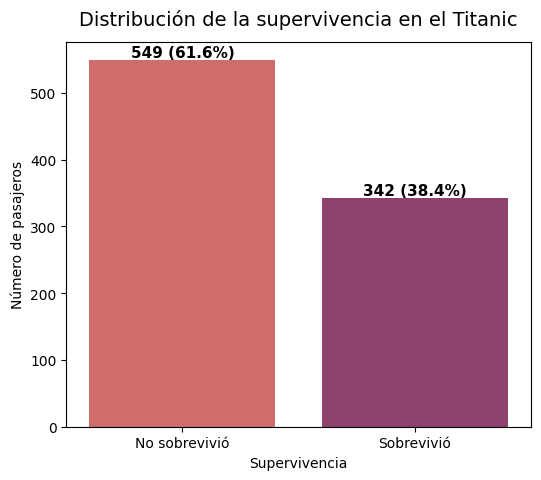

In [ ]:
total_passengers = len(df_titanic_train)
survivors = df_titanic_train['Survived'].sum()
survival_rate = survivors / total_passengers * 100

print(f"Total de pasajeros: {total_passengers}")
print(f"Sobrevivientes: {survivors}")
print(f"Probabilidad de supervivencia: {survival_rate:.2f}%")

plt.figure(figsize=(6,5))
ax = sns.countplot(x="Survived", data=df_titanic_train, palette="flare")
ax.set_xticklabels(["No sobrevivió", "Sobrevivió"])

#Etiquetas
plt.title("Distribución de la supervivencia en el Titanic", fontsize=14, pad=12)
plt.xlabel("Supervivencia")
plt.ylabel("Número de pasajeros")
counts = df_titanic_train['Survived'].value_counts().sort_index()
for i, val in enumerate(counts):
    percentage = (val / total_passengers) * 100
    plt.text(i, val, f"{val} ({percentage:.1f}%)",
             ha='center', va='bottom', fontsize=11, fontweight='bold')
plt.show()

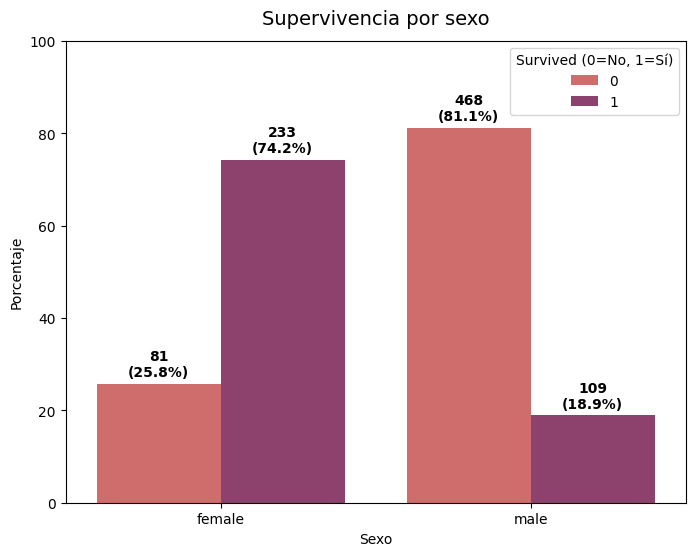

In [ ]:
ct_counts = pd.crosstab(df_titanic_train['Sex'], df_titanic_train['Survived'])
ct_perc   = ct_counts.div(ct_counts.sum(axis=1), axis=0) * 100

df_plot = (
    ct_perc.reset_index()
           .melt(id_vars='Sex', var_name='Survived', value_name='Percent')
    .merge(
        ct_counts.reset_index().melt(id_vars='Sex', var_name='Survived', value_name='Count'),
        on=['Sex','Survived']
    )
)

plt.figure(figsize=(8,6))
ax = sns.barplot(data=df_plot, x='Sex', y='Percent', hue='Survived', palette='flare')

# Etiquetas
for p, (_, row) in zip(ax.patches, df_plot.iterrows()):
    ax.text(p.get_x() + p.get_width()/2,
            p.get_height() + 1,
            f"{int(row['Count'])}\n({row['Percent']:.1f}%)",
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_title("Supervivencia por sexo", pad=12, fontsize=14)
ax.set_xlabel("Sexo")
ax.set_ylabel("Porcentaje")
ax.legend(title="Survived (0=No, 1=Sí)")
plt.ylim(0, 100)
plt.show()

### Supervivencia segmentada por clase (Pclass)

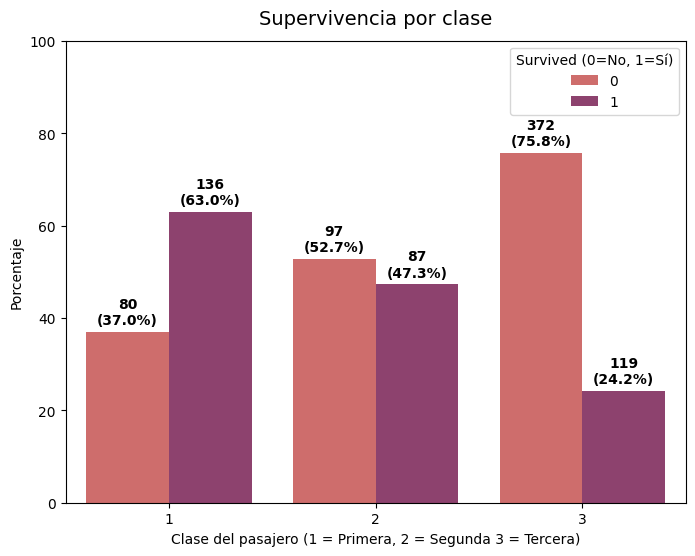

In [ ]:
ct_counts = pd.crosstab(df_titanic_train['Pclass'], df_titanic_train['Survived'])
ct_perc   = ct_counts.div(ct_counts.sum(axis=1), axis=0) * 100

df_plot = (
    ct_perc.reset_index()
           .melt(id_vars='Pclass', var_name='Survived', value_name='Percent')
    .merge(
        ct_counts.reset_index().melt(id_vars='Pclass', var_name='Survived', value_name='Count'),
        on=['Pclass','Survived']
    )
)

plt.figure(figsize=(8,6))
ax = sns.barplot(data=df_plot, x='Pclass', y='Percent', hue='Survived', palette='flare')

# Etiquetas
for p, (_, row) in zip(ax.patches, df_plot.iterrows()):
    ax.text(p.get_x() + p.get_width()/2,
            p.get_height() + 1,
            f"{int(row['Count'])}\n({row['Percent']:.1f}%)",
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_title("Supervivencia por clase", pad=12, fontsize=14)
ax.set_xlabel("Clase del pasajero (1 = Primera, 2 = Segunda 3 = Tercera)")
ax.set_ylabel("Porcentaje")
ax.legend(title="Survived (0=No, 1=Sí)")
plt.ylim(0, 100)
plt.show()

### Supervivencia segmentada por edad (Age)

El histograma muestra cómo se distribuyen las edades de los pasajeros sobrevivientes y no sobrevivientes:

- La mayoría de los pasajeros se concentraban entre los **20 y 40 años**, rango donde también hubo más muertes.  
- Los **niños pequeños (0–12 años)** tuvieron una mayor proporción de supervivencia en comparación con adultos y personas mayores, lo que refleja la regla de *"mujeres y niños primero"*.  
- Los **adultos jóvenes (20–40 años)** presentan la mayor cantidad de fallecidos, ya que eran el grupo más numeroso a bordo.  
- Los **mayores de 50 años** muestran tasas de supervivencia mucho más bajas, probablemente por menor prioridad de rescate y menor capacidad física para evacuar.  

En conclusión, la edad influyó en la probabilidad de supervivencia, destacando que los **niños tuvieron ventaja**, mientras que los adultos y ancianos se vieron más afectados por la tragedia.

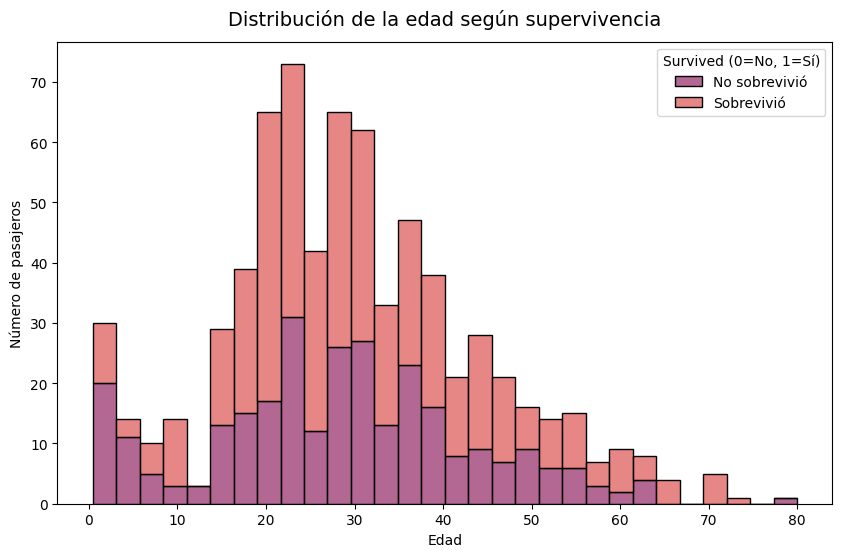

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(data=df_titanic_train, x="Age", hue="Survived", multiple="stack", bins=30, palette="flare")
plt.title("Distribución de la edad según supervivencia", fontsize=14, pad=12)
plt.xlabel("Edad")
plt.ylabel("Número de pasajeros")
plt.legend(title="Survived (0=No, 1=Sí)", labels=["No sobrevivió", "Sobrevivió"])
plt.show()

Resumen estadístico de las variables numéricas del dataset.  
Incluye métricas como:

- **count** → número de valores no nulos.  
- **mean** → promedio de la columna.  
- **std** → desviación estándar (variabilidad de los datos).  
- **min** → valor mínimo.  
- **25%, 50%, 75%** → percentiles (cuartiles que dividen la distribución de los datos).  
- **max** → valor máximo.  

Esto permite obtener una **visión rápida de la distribución y dispersión de los datos numéricos** en el dataset Titanic.

In [ ]:
df_titanic_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Análisis de valores nulos

Antes de transformar los datos, es importante identificar **qué columnas contienen valores faltantes**.  
El siguiente mapa de calor muestra con color azul las celdas que tienen valores nulos y en negro las que contienen datos.  

Esto nos permitirá visualizar rápidamente **qué variables necesitan limpieza o imputación** en la fase de Transformación.

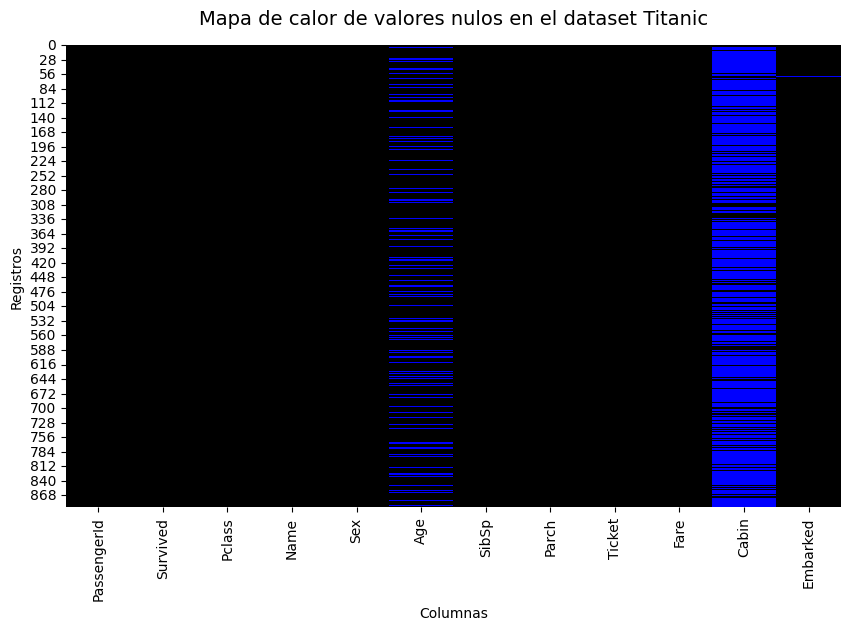

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df_titanic_train.isnull(),
            cmap=sns.color_palette(["black","blue"]),
            cbar=False)
plt.title("Mapa de calor de valores nulos en el dataset Titanic", fontsize=14, pad=15)
plt.xlabel("Columnas")
plt.ylabel("Registros")
plt.show()

/tmp/ipython-input-54597546.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_values.index, y=missing_values.values, palette="flare")


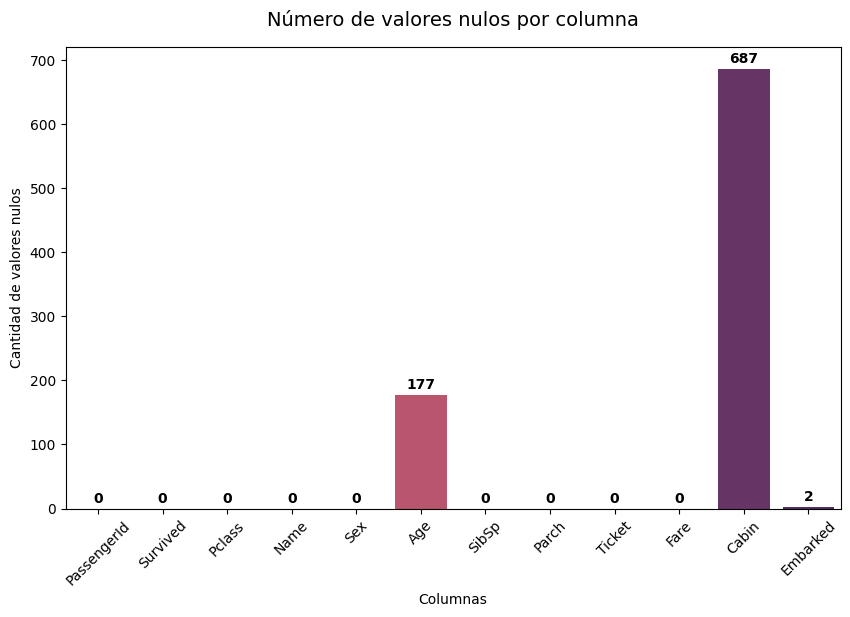

In [ ]:
missing_values = df_titanic_train.isnull().sum()
plt.figure(figsize=(10,6))
sns.barplot(x=missing_values.index, y=missing_values.values, palette="flare")

for i, val in enumerate(missing_values.values):
    plt.text(i, val + 5, str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title("Número de valores nulos por columna", fontsize=14, pad=15)
plt.xlabel("Columnas")
plt.ylabel("Cantidad de valores nulos")
plt.xticks(rotation=45)
plt.show()

/tmp/ipython-input-1770366462.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_percent.index, y=missing_percent.values, palette="flare")


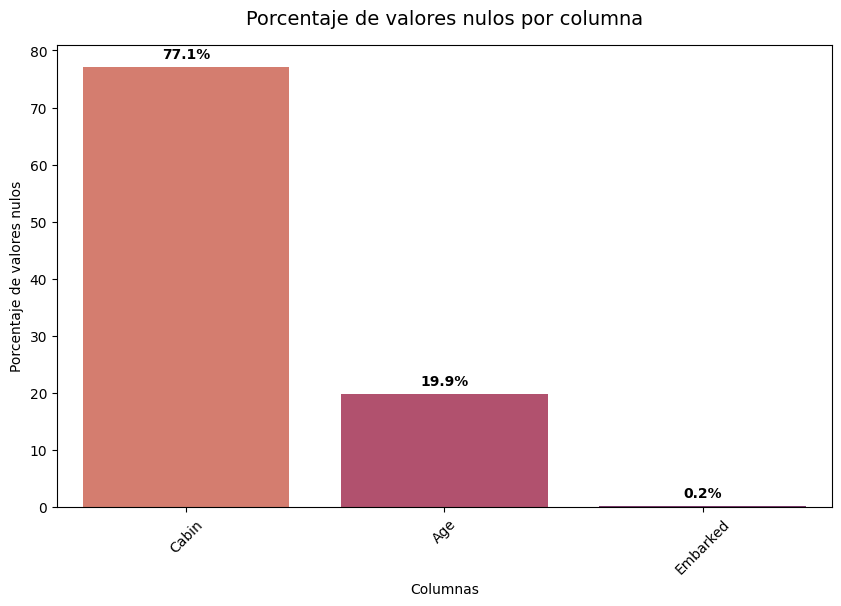

In [ ]:
missing_percent = (df_titanic_train.isnull().sum() / len(df_titanic_train)) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=missing_percent.index, y=missing_percent.values, palette="flare")
# Etiquetas
for i, val in enumerate(missing_percent.values):
    plt.text(i, val + 1, f"{val:.1f}%", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title("Porcentaje de valores nulos por columna", fontsize=14, pad=15)
plt.xlabel("Columnas")
plt.ylabel("Porcentaje de valores nulos")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Vamos a visualizar las primeras estadisticas de cada columna
df_titanic_train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Dooley, Mr. Patrick",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [ ]:
# Vemos que porcentaje sobrevivio y que porcentaje no lo hizo
df_titanic_train['Survived'].value_counts(normalize=True)

,proportion
Survived,
0,0.616162
1,0.383838


# Transformación
En esta etapa realizamos la **limpieza y transformación de datos**.  
Acciones principales:
- Imputación de valores nulos en `Cabin`, `Age` y `Embarked`.  
- Transformación de `Cabin` en nuevas variables (`CabinLetter`, `HasCabin`).  
- Creación de nuevas variables (features).  
- Codificación de variables categóricas (`Sex`, `Embarked`, etc.) para los modelos.

### Imputación y transformación de la variable Cabin

La columna `Cabin` presenta más del **77% de valores nulos**, por lo que no es viable imputarla de manera directa.  
En su lugar, realizamos tres estrategias:

1. **HasCabin:** variable binaria que indica si el pasajero tenía cabina registrada.  
2. **CabinLetter:** variable categórica que representa la cubierta (primera letra de la cabina) o "Unknown" si no estaba disponible.  
3. **Asignación de Cabina por Ticket Compartido:**  
En algunos casos, los pasajeros compartían el mismo ticket (ej. familias o sirvientes), lo que sugiere que también compartían cabina.  
Si un pasajero no tiene cabina registrada pero otro con el mismo ticket sí, se le asigna la misma cabina.

In [ ]:
# --- Primero vamos a extraer la letra de la cabina ---
df_titanic_train['CabinLetter'] = df_titanic_train['Cabin'].str[0]

# --- Visualizamos como se distribuyen las letras de la cabina con la clase para ver una relacion entre estas ---
cabin_class_table = pd.crosstab(df_titanic_train['CabinLetter'], df_titanic_train['Pclass'])
print(cabin_class_table)

Pclass        1  2  3
CabinLetter          
A            15  0  0
B            47  0  0
C            59  0  0
D            29  4  0
E            25  4  3
F             0  8  5
G             0  0  4
T             1  0  0


In [ ]:
# Distribución de HasCabin
plt.figure(figsize=(6,5))
ax = sns.countplot(x="HasCabin", data=df_titanic_train, palette="flare")
plt.title("Distribución de pasajeros con/ sin cabina registrada", fontsize=14, pad=12)
plt.xlabel("Tiene cabina (0=No, 1=Sí)")
plt.ylabel("Número de pasajeros")

# Etiquetas
counts = df_titanic_train['HasCabin'].value_counts().sort_index()
total = len(df_titanic_train)
for i, val in enumerate(counts):
    perc = val / total * 100
    ax.text(i, val, f"{val} ({perc:.1f}%)", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.show()

ValueError: Could not interpret value `HasCabin` for `x`. An entry with this name does not appear in `data`.

<Figure size 600x500 with 0 Axes>

#### Visualización de la variable Cabin transformada

Ticket, cabin,Pclass: Buscamos relacionar el número en Ticket con las cabinas. Si un número de ticket tiene asignado una cabina (cabin), se le asigna a los demás que tengan ese mismo. Esto lo hacemos para que se pueda usar la idea de clasificar la cabina por números y nombres para así relacionar el tipo de cabina con la clase (Pclass).

In [ ]:
#Reemplazamos los valores faltantes por medio de la mediana
df_titanic_test['Fare'] = df_titanic_test['Fare'].fillna(df_titanic_test['Fare'].median())

Name → Extraer el Título (Mr, Miss, etc.), luego el campo original se elimina.

In [ ]:
# Extraemos solamente el titulo
df_titanic_train['Title'] = df_titanic_train['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)

# Verificamos que solo estan los titulos de cada nombre
print(df_titanic_train['Title'].value_counts())

#Eliminamos la columna del nombre
df_titanic_train.drop(columns=['Name'], inplace=True)

Ticket → Demasiada variabilidad y ruido → eliminar después de crear TicketGroupSize e InGroup

In [ ]:
#Vamos a contar cuantas personas tienen el mismo numero del ticket, ya que si un grupo compartia el mismo numero puede que fueran juntas
df_titanic_train['TicketGroupSize'] = df_titanic_train.groupby('Ticket')['Ticket'].transform('count')

#Es un booleano para determinar si la persona viajaba en grupo o solo
df_titanic_train['InGroup'] = (df_titanic_train['TicketGroupSize'] > 1).astype(int)

df_titanic_train.drop(columns=['Ticket'], inplace=True)

Sex: convertido a variable binaria → male=0, female=1.

In [ ]:
df_titanic_train['Sex'] = df_titanic_train['Sex'].map({'male': 0, 'female': 1})

df_titanic_test['Sex'] = df_titanic_test['Sex'].map({'male': 0, 'female': 1})

Age: Imputar valores faltantes por medio del titulo y la mediana de cada grupo

In [ ]:
#Agrupamos por el titulo, seleccionamos la edad y a las filas que esten vacias vamos a calcular la mediana, con el transform le aplicamos este resultado a esa fila
df_titanic_train['Age'] = df_titanic_train.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))

#test['Age'] = test.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))

Embarked: Imputar valores por medio de la moda

In [ ]:
# Utilizamos fillna para llenar los campos vacios, reemplazandolos con la moda y utilizando el primer indice en el caso que nos devuelva mas de 1 valor
df_titanic_train['Embarked'] = df_titanic_train['Embarked'].fillna(df_titanic_train['Embarked'].mode()[0])

Fare: Imputamos el valor faltante por medio de la mediana para evitar outliers por valores extremos: ESTO ES EN TEST

Se dejó a un lado por las siguientes razones:


*   La variable CabinLetter esta altamente sesgada hacia la primera clase, con muy poca representacion hacia la segunda y tercera clase

*   Limita la capacidad predictiva y nos puede meter mas ruido que valor
mas del 75% de los pasajeros no tienen cabina
*   Casi toda la informacion esta en la primera clase

*   Tenemos riesgo de overfitting si el modelo aprende patrones de cabina que no generalizan

In [ ]:
# --- Visualizamos si el pasajero tiene cabina o no ---
df_titanic_train['HasCabin'] = df_titanic_train['Cabin'].notnull().astype(int)

# --- Vamos a ver la tasa de supervivencia por HasCabin para ver si tiene una fuerte correlacion el hecho de que tenga cabina o no
survival_by_cabin = df_titanic_train.groupby('HasCabin')['Survived'].mean()
print(survival_by_cabin)

In [ ]:
sns.barplot(x='HasCabin', y='Survived', data=df_titanic_train, palette="flare")
plt.title('Tasa de supervivencia según HasCabin')
plt.xticks([0, 1], ['Sin cabina', 'Con cabina'])
plt.ylabel('Tasa de supervivencia')

plt.show()

In [ ]:
# --- Eliminamos CabinLetter y Cabin porque no nos sirve ---
df_titanic_train.drop(columns=['CabinLetter', 'Cabin'], errors='ignore', inplace=True)
df_titanic_test.drop(columns=['Cabin'], errors='ignore', inplace=True)

Creamos una variable llamada FamilySize para contar el numero de familiares con los que viajaba

In [ ]:
df_titanic_train['FamilySize'] = df_titanic_train['SibSp'] + df_titanic_train['Parch']
#test['FamilySize'] = test['SibSp'] + test['Parch']

Creamos una variable booleana para verificar si iba con algun familiar o no

In [ ]:
df_titanic_train['IsAlone'] = (df_titanic_train['FamilySize'] == 0).astype(int)



*   Pclass: Clase del boleto

*   Sex: 0 = hombre; 1 = mujer

*   Age: Edad de la persona

*   Fare: Precio del boleto (lo podemos relacionar con la clase)
*   Embarked: Puerto de embarque (Lo podemos relacionar con la ubicacion en el barco)

*   Title: Lo extraimos del nombre para ver su titulo (estatus social)

*   TicketGroupSize: Tamaño del grupo que comparte el ticket, pueden ser sus vinculos sociales

*   InGroup: Un booleano para determinar si viaja solo o en grupo; captura vinculo social

*   HasCabin: Un booleano para determinar si tiene cabina o no
*   FamilySize: Total de sus familiares a bordo (SibSp + Parch) captura vinculo familiar
*   IsAlone: Para determinar si viaja completamente solo; captura vinculo familiar






In [ ]:
df_titanic_train.head()

#Hipotesis

Primero mostramos la correlacion de las variables con la variable survived

In [ ]:
# 1. Copia del dataset original
train_encoded = df_titanic_train.copy()

# 2. Codificación de Embarked (si es necesario)
if "Embarked" in train_encoded.columns:
    train_encoded["Embarked"] = train_encoded["Embarked"].astype(str).str.upper().str.strip()
    train_encoded["Embarked"] = train_encoded["Embarked"].map({"C": 0, "Q": 1, "S": 2})

# 3. Verificar que Sex ya esté codificado correctamente
print("Valores únicos en Sex:", train_encoded["Sex"].unique())

# 4. Calcular matriz de correlaciones numéricas
corr_matrix = train_encoded.corr(numeric_only=True)

# 5. Extraer correlaciones con Survived
corr_survived = corr_matrix["Survived"].drop("Survived").sort_values(ascending=False)

# 6. Heatmap completo
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de Correlaciones entre Variables", fontsize=14)
plt.tight_layout()
plt.show()


#Distribución de Supervivencia

In [ ]:
sns.countplot(x="Survived", data=df_titanic_train, palette="flare")
plt.title("Distribución de Supervivencia")
plt.xlabel("0 = No sobrevivió, 1 = Sobrevivió")
plt.show()

#Sexo vs supervivencia

Por la fuerza fisica y el instinto protector

In [ ]:
sns.barplot(x="Sex", y="Survived", data=df_titanic_train, palette="flare")
plt.title("Supervivencia por Sexo")
plt.ylabel("Proporción de supervivencia")
plt.xlabel("0 = Male, 1 = Female")
plt.show()

#Edad y autosuficiencia
Como los niños pequeños no tienen mucha fuerza o instinto de supervivencia tan arraigado, es dificil que puedan sobrevivir a menos que su padre/madre este cerca, pero esto aun asi no incrementa mucho su probabilidad de sobrevivir

In [ ]:
#Visualizamos la distribucion de edad y como se relaciona con la supervivencia
sns.histplot(data=df_titanic_train, x="Age", hue="Survived", bins=30, kde=True, palette="flare")
plt.title("Distribución de Edad por Supervivencia")
plt.show()

In [ ]:
#Agrupamos por rangos

#Primero vamos a dividirlo en 5 grupos
n_grupos = 5

# Creamos los rangos de edad
bins = np.linspace(df_titanic_train["Age"].min(), df_titanic_train["Age"].max(), n_grupos + 1)

#Generamos las etiquetas dinamicamente
labels = [f"{int(bins[i])}–{int(bins[i+1])}" for i in range(n_grupos)]

# Hacemos la agrupacion por los rangos de edad
df_titanic_train["AgeGroup"] = pd.cut(df_titanic_train["Age"], bins=bins, labels=labels, include_lowest=True)


sns.barplot(x="AgeGroup", y="Survived", data=df_titanic_train, palette="flare")
plt.title("Supervivencia por Grupo de Edad")
plt.xlabel("Grupo de Edad")
plt.ylabel("Tasa de Supervivencia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df_titanic_train["FamilySize"] = df_titanic_train["SibSp"] + df_titanic_train["Parch"]
sns.barplot(x="FamilySize", y="Survived", data=df_titanic_train, palette="flare")
plt.title("Supervivencia según Tamaño de Familia")
plt.show()

Supervivencia por clase

In [ ]:
sns.barplot(x="Pclass", y="Survived", data=df_titanic_train, palette="flare")
plt.title("Supervivencia por Clase")
plt.show()

# 1. Clasificacion supervisada (baseline)
Clasificacion supervisada: Tipo de aprendizaje automatico donde el modelo aprende a predecir una etiqueta (survived) a partir de ejemplos etiquetados (train.csv).

*   **3 clasificadores: Regresion Logistica, Random Forest, SVM/KNN.**
      
      Regresion Logistica: Lineal, interpretable y rapido; nos permite ver como cada variable afecta la probabilidad de supervivencia.

      Random Forest: Modelo de arboles, no lineal, robusto; captura interacciones entre variables; es menos interpretable pero suele tener mejor rendimiento

      KNN: Clasifica segun los vecinos mas cercanos

      El objetivo de hacerlo con estos tres modelos es comparar enfoques distintos y ver cual se adapta mejor a nuestros datos.


*   **Pipeline con ColumnTransformer.**

      El pipeline es la estructura que encadena pasos como preprocesamiento y modelado.

      El ColumnTransformer nos permite aplicar transformaciones distintas a columnas numericas y categoricas.

      Esto nos lo piden para garantizar que el flujo sea: Reproducible, modular, compatible con validacion cruzada y limpio.


*   **Validacion cruzada estratificada (5 folds)**

      Esto divide el dataset en 5 partes (folds)

      Entrena en 4, valida en 1 y repite 5 veces

      Estrateficada se refiere a que mantiene la proporcion de clases (survived) en cada fold

      Esto lo haremos para evaluar el modelo de forma robusta y evitar que los resultados dependan de una sola division de datos. Nos sirve para evitar overfitting y obtener metricas confiables


*   **Reportar: AUC, Accuracy, Precision, Recall.**

      Accuracy: Medimosel porcentaje de predicciones correctas

      Precision: Medimos de los que predijo como 'sobrevivio', cuantos realmente sobrevivieron?

      Recall: Medimos de los que realmente sobrevivieron, cuantos detecto el modelo?

      AUC: Medimos que tan bien separa el modelo ambas clases (area bajo la curva ROC)

      Esto es necesario debido a que Accuracy puede no ser tan acertada si las clases estan desbalanceadas. AUC y Recall nos muestran si el modelo realmente distingue bien entre sobrevivientes y no sobrevivientes


*   **Visualizacion: Matriz de confusion, curva ROC.**

      Matriz de confusion: Nos muestra los verdaderos positivos, falsos positivos, etc. Nos ayuda a entender los errores de cada modelo.

      Curva ROC: Visualizamos el trade-off entre sensibilidad (recall) y especificidad. El area bajo la curva (AUC) nos resume el rendimiento.



Primero establecemos nuestros features y nuestra variable objetivo

In [ ]:
# Nuestras features
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title',
            'TicketGroupSize', 'InGroup', 'HasCabin', 'FamilySize', 'IsAlone']

X = df_titanic_train[features]
y = df_titanic_train['Survived']

Pipeline con **ColumnTransformer**

Separamos las columnas numericas y categoricas para aplicar las transformaciones correspondientes

Esto nos sirve para integrar el preprocesamiento dentro del pipeline de modelado, sin tener que hacerlo manualmente antes. Asi podemos usar validacion cruzada, comparar modelos y hacer predicciones sin preocuparnos por inconsistencias en los datos.

In [ ]:
# Los features (columnas) numericas que utilizaremos de nuestro dataset
# Las vamos a escalar con StandardScaler para que tengan media 0 y desviacion estandar 1. Es importante para KNN que es sensible a la escala
numeric_features = ['Age', 'Fare', 'TicketGroupSize', 'FamilySize']

#Los features (columnas) categoricas que utilizaremos de nuestro dataset
# Las vamos a codificar con OneHotEncoder, para convertir cada categoria en una columna binaria.
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'InGroup', 'HasCabin', 'IsAlone']

# Transformador: ColumnTransformer
# Aplicamos StandardScaler a nuestras columnas numericas
#Aplicamos OneHotEncoder solo a nuestras columnas categoricas
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features) #handle_unknown='ignore' nos evita errores si aparece una categoria nueva en test que no estaba en train
])

Definimos los clasificadores (LogisticRegression, RandomForest y KNeighbors)

Aqui preparamos los modelos de clasificacion supervisada que usaremos en nuestro baseline

In [ ]:
# Modelos
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000), # Modelo lineal que estima la probabilidad de que un evento ocurra. Tenemos suficientes iteraciones para converger.
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42), # Modelo de arboles de decision que captura relaciones no lineales y es robusto ante ruido. 100 arboles en el bosque y aseguramos reproducibilidad (misma semilla = mismos resultados)
    'KNN': KNeighborsClassifier(n_neighbors=5) # Este modelo clasifica segun los ejemplos mas similares. Usamos los 5 vecinos mas cercanos para decidir la clase.
}

Validacion cruzada estratificada

In [ ]:
# Dividimos el dataset en 5 partes, mezclamos los datos antes de dividirlos y aseguramos que los resultados sean reproducibles (misma semilla = misma division)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Creamos un diccionario que le dice a cross_validate que metricas vamos a calcular en cada fold
# Nosotros le damos el nombre que queramos y cada valor es el identificador que scikit-learn reconoce
scoring = {
    'AUC': 'roc_auc', # Que tan bien separa el modelo ambas clases
    'Accuracy': 'accuracy', # Que porcentaje de predicciones fueron correctas
    'Precision': 'precision', # De los que el modelo predijo como 'sobrevivientes', cuantos realmente lo eran?
    'Recall': 'recall' # De los que realmente sobrevivieron, ¿cuántos detectó el modelo?
}


Entrenamos y evaluamos cada modelo

In [ ]:
# Inicializamos un diccionario donde guardaremos las metricas de cada modelo
results = {}

#Iteramos sobre cada modelo
for name, model in models.items(): # Recorremos el diccionario models; 'name' es el nombre del modelo y 'model' es la instancia del clasificador
    #Creamos el pipeline; con esto nos aseguramos que cada modelom use exactamente el mismo preprocesamiento para una comparacion justa entre modelos.
    pipeline = Pipeline([
        ('preprocessing', preprocessor), # Aplicamos el ColumnTransformer (preprocessor) para escalar y codificar nuestras variables
        ('classifier', model) # Entrenamos el modelo correspondiente
    ])
    #Validacion cruzada estratificada
    #Entrenamos el pipeline en 5 folds, evaluamos las metricas que definimos en 'scoring' y guardamos los resultados en un diccionario llamado scores.
    scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring) # Este diccionario guardara las listas con los resultados de cada metrica en cada fold

    #Calculamos el promedio de cada metrica
    # Accedemos a cada metrica en scores, calculamos su promedio con '.mean()' y guardamos ese resultado en el diccionario results bajo el nombre del modelo
    results[name] = {metric: scores[f'test_{metric}'].mean() for metric in scoring}

Mostramos los resultados

In [ ]:
# Convertimos a DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

Visualizamos la matriz de confusion y la curva ROC

In [ ]:
# Separamos datos del entrenamiento y la validacion
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Creamos el pipeline con preprocesamiento y modelo
logreg_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Entrenamos el modelo
logreg_pipeline.fit(X_train, y_train)

# Predecimos en el conjunto de validación
y_pred = logreg_pipeline.predict(X_val)

# Visualizamos la matriz de confusión
ConfusionMatrixDisplay.from_predictions(
    y_val,
    y_pred,
    display_labels=['No sobrevivió', 'Sobrevivió'],
    cmap='Blues'
)

plt.title("Matriz de Confusión - Regresión Logística")
plt.show()

In [ ]:
# --- Matriz de confusion pars Random Forest

# Separamos datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Creamos el pipeline con preprocesamiento y modelo Random Forest
rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Entrenamos el modelo
rf_pipeline.fit(X_train, y_train)

# Predecimos en el conjunto de validación
y_pred = rf_pipeline.predict(X_val)

# Visualizamos la matriz de confusión
ConfusionMatrixDisplay.from_predictions(
    y_val,
    y_pred,
    display_labels=['No sobrevivió', 'Sobrevivió'],
    cmap='Blues'
)

plt.title("Matriz de Confusión - Random Forest")
plt.show()


In [ ]:
# --- Matriz de confusion para KNN ---

# Separamos datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Creamos el pipeline con preprocesamiento y modelo KNN
knn_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

# Entrenamos el modelo
knn_pipeline.fit(X_train, y_train)

# Predecimos en el conjunto de validación
y_pred = knn_pipeline.predict(X_val)

# Visualizamos la matriz de confusión
ConfusionMatrixDisplay.from_predictions(
    y_val,
    y_pred,
    display_labels=['No sobrevivió', 'Sobrevivió'],
    cmap='Blues'
)

plt.title("Matriz de Confusión - KNN")
plt.show()

In [ ]:
# --- Curva ROC para la regresion logistica ---

# Separamos datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Creamos pipeline con preprocesamiento y modelo
logreg_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Entrenamos el modelo
logreg_pipeline.fit(X_train, y_train)

# Obtenemos probabilidades de clase positiva
y_proba = logreg_pipeline.predict_proba(X_val)[:, 1]

# Visualizamos la curva ROC
RocCurveDisplay.from_predictions(y_val, y_proba)

plt.title("Curva ROC - Regresión Logística")
plt.show()

In [ ]:
# --- Curva ROC para random forest ---

# Separamos datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Creamos pipeline con preprocesamiento y modelo Random Forest
rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Entrenamos el modelo
rf_pipeline.fit(X_train, y_train)

# Obtenemos probabilidades de clase positiva
y_proba = rf_pipeline.predict_proba(X_val)[:, 1]

# Visualizamos la curva ROC
RocCurveDisplay.from_predictions(y_val, y_proba)

plt.title("Curva ROC - Random Forest")
plt.show()

In [ ]:
# --- Curva ROC para KNN ---

# Separamos datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Creamos pipeline con preprocesamiento y modelo KNN
knn_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

# Entrenamos el modelo
knn_pipeline.fit(X_train, y_train)

# Obtenemos probabilidades de clase positiva
y_proba = knn_pipeline.predict_proba(X_val)[:, 1]

# Visualizamos la curva ROC
RocCurveDisplay.from_predictions(y_val, y_proba)

plt.title("Curva ROC - KNN")
plt.show()

Comparamos las tres curvas de ROC

Esto lo hacemos para visualizar cual modelo separa mejor las clases de una persona (si sobrevivio o no)

In [ ]:
# Separamos datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Definimos los modelos
modelos = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# Inicializamos gráfica
plt.figure(figsize=(8, 6))

# Entrenamos cada modelo y graficar su curva ROC
for nombre, modelo in modelos.items():
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', modelo)
    ])

    pipeline.fit(X_train, y_train)
    y_proba = pipeline.predict_proba(X_val)[:, 1]

    fpr, tpr, _ = roc_curve(y_val, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{nombre} (AUC = {roc_auc:.3f})')


plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC = 0.5)')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Comparación de Curvas ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Analisis no supervisado (k-means)

*   Aplicar K-means con K = 4
*   Reportar: tasa de supervivencia por cluster, numero de pasajeros
*   Interpretar arquetipos (ej.: Mujeres jovenes de 1a clase).



Seleccionamos las variables para nuestro cluistering

Es decir, vamos a elegir las variables para segmentar los perfiles de nuestros pasajeros, aqui como es "no supervisado" no agregamos la variable survived

In [ ]:
from sklearn.preprocessing import StandardScaler

# Nuestras variables para clustering
cluster_features = ['Pclass', 'Sex', 'Age', 'Fare', 'FamilySize', 'IsAlone']

X_cluster = df_titanic_train[cluster_features]

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

Aplicamos K-Means con k = 4

In [ ]:
from sklearn.cluster import KMeans

# Definimos nuestro modelo
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
df_titanic_train['Cluster'] = kmeans.fit_predict(X_scaled)

Reportamos la tasa de supervivencia por cluster

In [ ]:
# Agrupamos por cluster y calculamos las metricas
cluster_summary = df_titanic_train.groupby('Cluster').agg({
    'Survived': ['mean', 'count'],
    'Pclass': 'mean',
    'Sex': 'mean',
    'Age': 'mean',
    'Fare': 'mean',
    'FamilySize': 'mean',
    'IsAlone': 'mean'
})

cluster_summary.columns = ['SurvivalRate', 'PassengerCount', 'AvgPclass', 'AvgSex', 'AvgAge', 'AvgFare', 'AvgFamilySize', 'AvgIsAlone']
print(cluster_summary)

Interpretamos los arquetipos

Usamos los promedios por cluster para entender qué tipo de perfil representa cada grupo. Por ejemplo:

*   AvgSex ≈ 1 → mayoría mujeres
*   AvgPclass ≈ 1 → primera clase
*   AvgAge < 30 → jóvenes
*   AvgIsAlone ≈ 0 → viajaban acompañados

In [ ]:
def interpretar_cluster(row):
    sexo = 'Mujeres' if row['AvgSex'] > 0.5 else 'Hombres'
    clase = f"{int(round(row['AvgPclass']))}ª clase"
    edad = 'jóvenes' if row['AvgAge'] < 30 else 'mayores'
    acompañamiento = 'acompañados' if row['AvgIsAlone'] < 0.5 else 'solos'
    return f"{sexo} {edad} de {clase}, {acompañamiento}"

cluster_summary['Arquetipo'] = cluster_summary.apply(interpretar_cluster, axis=1)
print(cluster_summary[['PassengerCount', 'SurvivalRate', 'Arquetipo']])

Visualizacion de los clusters con PCA

In [ ]:
# Aplicamos PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_titanic_train['PCA1'] = X_pca[:, 0]
df_titanic_train['PCA2'] = X_pca[:, 1]

# Creamos diccionario de nombres de cluster
cluster_labels = cluster_summary['Arquetipo'].to_dict()  # Usa el índice como clave (número de cluster)

# Mapeamos nombres al dataframe
df_titanic_train['ClusterLabel'] = df_titanic_train['Cluster'].map(cluster_labels)

# 4. Graficamos
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_titanic_train, x='PCA1', y='PCA2', hue='ClusterLabel', palette='tab10')
plt.title("Visualización de Clusters en 2D (PCA)", fontsize=14)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Arquetipo de Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Analisis de supervivencia por cluster

In [ ]:
# Creamos el DataFrame con etiquetas interpretativas
cluster_plot_df = cluster_summary.reset_index()[['Cluster', 'SurvivalRate', 'Arquetipo']]

# Graficamos
plt.figure(figsize=(10, 6))
sns.barplot(data=cluster_plot_df, x='Arquetipo', y='SurvivalRate', palette='viridis')
plt.title("Tasa de Supervivencia por Arquetipo de Cluster", fontsize=14)
plt.ylabel("Supervivencia Promedio")
plt.xlabel("Perfil del Cluster")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3. Estrategia híbrida  

## Ruta A: Mixture of Experts (MoE)

Definimos tres modelos (supervisados) que actuarán como expertos locales dentro de cada cluster (no supervisado):

logreg: Logistic Regression
rf: Random Forest
knn: K-Nearest Neighbors
Cada cluster tendrá un VotingClassifier que combinará estos expertos.

In [ ]:
# Diccionario de modelos base
base_models = {
    'logreg': LogisticRegression(max_iter=1000),
    'rf': RandomForestClassifier(n_estimators=100, random_state=42),
    'knn': KNeighborsClassifier(n_neighbors=5)
}

Creamos un preprocesador global utilizando ColumnTransformer (como en nuestro baseline).

Al ejecutar *preprocessor.fit(train[features])*, el preprocesador aprende las medias y desviaciones de las columnas numéricas y registra todas las categorías presentes en las columnas categóricas, pero se hace sobre todo el dataset de entrenamiento y no por cluster.

De esta manera nos aseguramos que todos los expertos entrenados por cluster vean exactamente las mismas columnas transformadas, evitando inconsistencias en las dimensiones de los datos (*n_features*) al momento de hacer predicciones.

In [ ]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])
preprocessor.fit(df_titanic_train[features])

Aplicamos la transformación a todo el conjunto de entrenamiento y validación.

In [ ]:
X_train_transformed = preprocessor.transform(X_train)
X_val_transformed = preprocessor.transform(X_val)

**Entrenamiento**

En este paso, iteramos sobre cada cluster (previamente definido por K-means). Para cada uno, se seleccionan únicamente las filas del conjunto de entrenamiento que pertenecen a ese grupo, generando así un subconjunto de datos (*X_cluster* y *y_cluster*) ya transformados por el preprocesador global.

Sobre este subconjunto se entrena un *VotingClassifier*, que combina los tres modelos base (Logistic Regression, Random Forest y KNN) utilizando soft voting; es decir, cada modelo calcula la probabilidad de pertenencia a cada clase y estas probabilidades se promedian para determinar la predicción final del cluster.
Una vez entrenado, este VotingClassifier se guarda como el “experto” encargado de ese cluster en particular.

Es en esta parte donde aplicamos una estrategía híbrida:
- No supervisado: K-means define clusters.
- Supervisado: cada cluster tiene un conjunto de expertos (LR, RF, KNN) que predicen.

In [ ]:
expert_models = {}

for cluster_id in df_titanic_train['Cluster'].unique():
    cluster_idx = df_titanic_train.loc[X_train.index, 'Cluster'] == cluster_id
    X_cluster = X_train_transformed[cluster_idx]
    y_cluster = y_train[cluster_idx]

    # Crear un VotingClassifier con los tres expertos
    voting_clf = VotingClassifier(
        estimators=[(name, model) for name, model in base_models.items()],
        voting='soft'
    )

    voting_clf.fit(X_cluster, y_cluster)
    expert_models[cluster_id] = voting_clf

**Predicciones**

En este paso, se asigna a cada fila del conjunto de validación el cluster al que pertenece, recuperando la información de cluster que fue generada previamente por K-means sobre todo el dataset de entrenamiento. Luego, se itera sobre cada cluster y se localizan las posiciones relativas en *X_val* que corresponden a ese grupo; con esas posiciones se seleccionan únicamente las observaciones del cluster actual (X_subset). Cada uno de estos grupos de pasajeros es enviado al VotingClassifier específico del cluster.

 Las predicciones generadas por cada experto se colocan en las posiciones correctas dentro del vector *y_pred_hybrid*. De esta manera, cada pasajero es evaluado por el experto correspondiente a su cluster, asegurando que los patrones locales de cada grupo sean capturados correctamente.

In [ ]:
y_pred_hybrid = np.zeros(len(X_val))
val_cluster_ids = df_titanic_train.loc[X_val.index, 'Cluster']

for cluster_id in df_titanic_train['Cluster'].unique():
    idx_relative = np.where(val_cluster_ids.values == cluster_id)[0]
    if len(idx_relative) == 0:
        continue

    X_subset = X_val_transformed[idx_relative]
    model = expert_models[cluster_id]
    y_pred_hybrid[idx_relative] = model.predict(X_subset)

**Visualización**


Desplegamos las métricas de desempeño, junto a la Matriz de Confusión y la Curva ROC

In [ ]:
# Métricas
print("Accuracy:", accuracy_score(y_val, y_pred_hybrid))
print("Precision:", precision_score(y_val, y_pred_hybrid))
print("Recall:", recall_score(y_val, y_pred_hybrid))
print("AUC:", roc_auc_score(y_val, y_pred_hybrid))

In [ ]:
# --- Matriz de Confusión para MoE por clusters ---
ConfusionMatrixDisplay.from_predictions(
    y_val, y_pred_hybrid, display_labels=['No sobrevivió', 'Sobrevivió'], cmap='Blues'
)
plt.title("Matriz de Confusión - Ruta A MoE por clusters")
plt.show()

In [ ]:
# --- Curva ROC para MoE por clusters ---

# Inicializamos el vector de probabilidades
y_prob_hybrid = np.zeros(len(X_val))
val_cluster_ids = df_titanic_train.loc[X_val.index, 'Cluster']

# Obtenemos probabilidades por cluster
for cluster_id in df_titanic_train['Cluster'].unique():
    idx_relative = np.where(val_cluster_ids.values == cluster_id)[0]
    if len(idx_relative) > 0:
        X_subset = X_val_transformed[idx_relative]
        model = expert_models[cluster_id]

        # Obtenemos probabilidades de clase positiva
        y_prob_hybrid[idx_relative] = model.predict_proba(X_subset)[:, 1]

# Visualizamos la curva ROC
RocCurveDisplay.from_predictions(y_val, y_prob_hybrid)
plt.title("Curva ROC - MoE por Clusters")
plt.show()

## Ruta B: Cluster como feature adicional

In [ ]:
# Nuestras features (Agregamos la feature de "Cluster")
features_B = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title',
            'TicketGroupSize', 'InGroup', 'HasCabin', 'FamilySize', 'IsAlone', 'Cluster']

X = df_titanic_train[features_B]
y = df_titanic_train['Survived']

In [ ]:
# Los features (columnas) numericas que utilizaremos de nuestro dataset
numeric_features_B = ['Age', 'Fare', 'TicketGroupSize', 'FamilySize']

#Los features (columnas) categoricas que utilizaremos de nuestro dataset. Se agrega 'Cluster'
categorical_features_B = ['Pclass', 'Sex', 'Embarked', 'Title', 'InGroup', 'HasCabin', 'IsAlone', 'Cluster']

# Transformador: ColumnTransformer
# Aplicamos StandardScaler a nuestras columnas numericas
# Aplicamos OneHotEncoder solo a nuestras columnas categoricas
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features_B),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_B) #handle_unknown='ignore' nos evita errores si aparece una categoria nueva en test que no estaba en train
])

In [ ]:
results_B = {}
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', model)
    ])
    scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring)
    results_B[name] = {metric: scores[f'test_{metric}'].mean() for metric in scoring}

In [ ]:
# Convertimos a DataFrame
results_df_B = pd.DataFrame(results_B).T
print(results_df_B)

Los resultados obtenidos indican que no existe una diferencia significativa en las métricas al comparar los modelos que utilizan la feature de 'Cluster' con aquellos que no la consideran. Por lo tanto, podemos concluir que agregar esta variable no aporta una mejora relevante en el desempeño de los modelos y, en este caso, no justifica su inclusión.

# Discusión

- **¿Qué se gana o pierde al introducir clusters?**  Se gana interpretabilidad por arquetipos con diferencias reales de supervivencia (ejemplo: el Cluster 2 ~77.6% vs. Cluster 1 ~23.8%), lo que ayuda a explicar patrones por perfil (mujeres 1ª clase acompañadas vs. hombres 3ª clase solos). Se pierde **rendimiento y simplicidad** la Ruta A (Mixture of Experts por cluster) baja a AUC ≈ 0.768 en validación, además añadir clusters no mejora métricas frente al baseline.

- **¿Cambió el mejor modelo?** No. El baseline de Regresión Logística sigue siendo el mejor por AUC (~0.870 con CV). Con Ruta B (Cluster como feature) las métricas quedan prácticamente iguales (LogReg AUC ~0.8695), y la Ruta A (MoE por cluster) rinde peor (AUC ~0.768). En resumen, introducir clustering no mejoró tu mejor modelo y, en la variante MoE, lo degradó.

- **Riesgos de fuga de información.**  

  - **Clustering fuera del split/CV**: En el análisis, **K-means se ajusta con todo el dataset** y luego se reutiliza la etiqueta de `Cluster` para el conjunto de validación (`val_cluster_ids`), filtrando información del fold de validación.  
  - **Imputaciones globales**: La variable **Age se imputa con la mediana de Title** y **Embarked con la moda** calculadas directamente sobre todo el dataset.
  - **Features con conocimiento global**: Variables como **TicketGroupSize/InGroup** se calculan a partir de todo el dataset, lo que implica fuga de información.